In [18]:
import pandas as pd
import numpy as np
import sqlite3
from tqdm import tqdm
import pickle
from pandarallel import pandarallel
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
from goatools.obo_parser import GODag
from goatools.mapslim import mapslim
from goatools.gosubdag.gosubdag import GoSubDag
import requests
import os
import re
import networkx as nx


from vocabulary_functions import load_tokenizers
from go_functions import (
    create_unit_documents, create_go_labels, create_bertopic_model, 
    create_graph_aware_bertopic_model, split_data, GOHierarchyComparator,
    compare_hierarchies, compare_tokenization_methods_hierarchical
)

ImportError: cannot import name 'compare_tokenization_methods_hierarchical' from 'go_functions' (/cta/users/bsuyunu/github/evolutionary-subword-tokenization/Prog/go_functions.py)

In [3]:
pandarallel.initialize(nb_workers=20, progress_bar=True)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
# --- GO DAG and GO Slim Setup ---
ob_url = "http://purl.obolibrary.org/obo/go/go-basic.obo"
obo_path = "go-basic.obo"
if not os.path.exists(obo_path):
    with open(obo_path, "w") as f:
        f.write(requests.get(obo_url).text)
go_dag = GODag(obo_path)

goslim_url = "http://current.geneontology.org/ontology/subsets/goslim_generic.obo"
goslim_path = "goslim_generic.obo"
if not os.path.exists(goslim_path):
    with open(goslim_path, "w") as f:
        f.write(requests.get(goslim_url).text)
goslim_dag = GODag(goslim_path)
goslim_terms = set(goslim_dag.keys())
go_subdag_slim = GoSubDag(goslim_terms, go_dag)
goslim_id2name = {go_id: go_dag[go_id].name for go_id in goslim_terms}
goslim_name2id = {go_dag[go_id].name: go_id for go_id in goslim_terms}

go-basic.obo: fmt(1.2) rel(2025-03-16) 43,544 Terms
goslim_generic.obo: fmt(1.2) rel(go/2025-03-16/subsets/goslim_generic.owl) 206 Terms
 GoSubDag: 206 sources in 335 GOs rcnt(True). 65 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()


In [5]:
# --- Tokenizer and Vocabulary Configuration ---
# vocab_sizes = [800, 1600, 3200, 6400, 12800, 25600]
vocab_sizes = [3200, 6400]
uniref_id = "50"

tokenizer_opts_list = [
    {
        'is_mut': False,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': True,
        'subs_matrix': 'pam70',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
]

tokenizer_list = load_tokenizers(tokenizer_opts_list, 'hf')
inner_vocab_list = load_tokenizers(tokenizer_opts_list, 'vocab')

vocab_list = {name: list(set(tok.get_vocab().keys())) for name, tok in tokenizer_list.items()}
methods = [name[:-len(str(vocab_sizes[0]))-1] for name in list(tokenizer_list.keys())[::len(vocab_sizes)]]
methods2names = {mn: mn.replace('mut', 'evo').replace('std', '').replace('blosum', 'BLOSUM').replace('pam', 'PAM').replace('pre', 'Pre') for mn in methods}
methods2names = {k: ' '.join(v.split()[:-2]) if 'evoBPE' in v else v for k, v in methods2names.items()}

In [6]:
# --- Vocabulary Lineage Construction ---
vocab_lineage_list = {}
for k, v in inner_vocab_list.items():
    vocab_lineage_list[k] = {token: {
        'frequency': -1, 'order': -1, 'parent_pair': [], 'parent_mutation': "",
        'parent_mutation_similarity': -1, 'partner_pair_self': False,
        'partner_pair_left': [], 'partner_pair_right': [], 'child_pair': [], 'child_mutation': []
    } for token in v.keys()}

for method_name, vocab in tqdm(inner_vocab_list.items(), desc="Building Vocabulary Lineage"):
    for token, inner_elements in vocab.items():
        lineage = vocab_lineage_list[method_name][token]
        lineage['frequency'] = inner_elements.get('frequency', -1)
        lineage['order'] = inner_elements.get('order', -1)
        lineage['parent_pair'] = inner_elements.get('pair', [])
        lineage['parent_mutation'] = inner_elements.get('parent', "")
        lineage['parent_mutation_similarity'] = inner_elements.get('similarity', -1)

        if 'pair' in inner_elements:
            p1, p2 = inner_elements['pair']
            if p1 == p2:
                vocab_lineage_list[method_name][p1]['partner_pair_self'] = True
                vocab_lineage_list[method_name][p1]['child_pair'].append(token)
            else:
                vocab_lineage_list[method_name][p1]['partner_pair_right'].append(p2)
                vocab_lineage_list[method_name][p2]['partner_pair_left'].append(p1)
                vocab_lineage_list[method_name][p1]['child_pair'].append(token)
                vocab_lineage_list[method_name][p2]['child_pair'].append(token)
        if 'parent' in inner_elements:
            parent = inner_elements['parent']
            vocab_lineage_list[method_name][parent]['child_mutation'].append(token)

Building Vocabulary Lineage:   0%|          | 0/6 [00:00<?, ?it/s]

Building Vocabulary Lineage: 100%|██████████| 6/6 [00:00<00:00, 204.38it/s]


In [7]:
# --- Database Connection and Data Loading ---
db_file = "/cta/share/users/uniprot/human/human.db"
conn = sqlite3.connect(db_file)

df_protein = pd.read_sql(f"SELECT Entry as uniprot_id, Sequence as sequence FROM proteins WHERE Entry IN (SELECT uniprot_accession FROM uniref{uniref_id}_distilled)", conn)
df_protein = df_protein[df_protein['sequence'].str.len() < 3000].reset_index(drop=True)

df_protein_sliced = pd.read_sql(f"SELECT uniprot_id, sequence FROM uniref{uniref_id}_domain_sliced_plddt70", conn)
df_protein_sliced = df_protein_sliced[df_protein_sliced['uniprot_id'].isin(df_protein['uniprot_id'])].reset_index(drop=True)

df_quickgo = pd.read_sql(f"SELECT uniprot_id, go_id, go_evidence FROM uniprot_quickgo_annotations", conn)
df_quickgo = df_quickgo[df_quickgo['uniprot_id'].isin(df_protein['uniprot_id'])]

# Filter by evidence code
go_evidence_experimental = ['EXP', 'IDA', 'IPI', 'IMP', 'IGI', 'IEP']
go_evidence_computational = ['ISS', 'ISO', 'ISA', 'ISM', 'RCA', 'TAS', 'IEA']
df_quickgo = df_quickgo[df_quickgo['go_evidence'].isin(go_evidence_experimental + go_evidence_computational)].reset_index(drop=True)

# Convert go_ids to go_slim_ids
df_quickgo['go_slim_id'] = df_quickgo['go_id'].apply(lambda x: list(mapslim(x, go_dag, goslim_dag)[0]) if x in go_dag else [])
df_quickgo['go_slim_id'] = df_quickgo['go_slim_id'].apply(lambda x: x[0] if len(x) > 0 else '')
df_quickgo = df_quickgo[df_quickgo['go_slim_id'] != '']

# Drop duplicates
df_quickgo = df_quickgo.groupby(['uniprot_id', 'go_slim_id']).count().reset_index().sort_values(['uniprot_id', 'go_id'], ascending=False)
df_quickgo = df_quickgo.drop(columns=['go_id', 'go_evidence']).rename(columns={'go_slim_id': 'go_id'}).reset_index(drop=True)

# Drop infrequent go terms
df_quickgo = df_quickgo[df_quickgo['go_id'].isin(df_quickgo['go_id'].value_counts()[df_quickgo['go_id'].value_counts() > 20].index)].reset_index(drop=True)

# Add GO term information
df_quickgo['go_name'] = df_quickgo['go_id'].apply(lambda go_id: go_dag[go_id].name)
df_quickgo['go_aspect'] = df_quickgo['go_id'].apply(lambda go_id: go_dag[go_id].namespace)

conn.close()

df_quickgo

uniprot_id       go_id                                  go_name  \
0           X6RLR1  GO:0000910                              cytokinesis   
1           X6RLR1  GO:0005730                                nucleolus   
2           X6RLR1  GO:0005829                                  cytosol   
3           X6RLN4  GO:0005829                                  cytosol   
4           X6RL45  GO:0016787                       hydrolase activity   
...            ...         ...                                      ...   
144618  A0A024CHX5  GO:0016787                       hydrolase activity   
144619  A0A024CHX5  GO:0005576                     extracellular region   
144620  A0A023T4H3  GO:0140096  catalytic activity, acting on a protein   
144621  A0A023IQH3  GO:0007155                            cell adhesion   
144622  A0A023HJ61  GO:0003924                          GTPase activity   

                 go_aspect  
0       biological_process  
1       cellular_component  
2       cellular_component  
3       cellular_component  
4       molecular_function  
...                    ...  
144618  molecular_function  
144619  cellular_component  
144620  molecular_function  
144621  biological_process  
144622  molecular_function  

[144623 rows x 4 columns]

In [8]:
df_quickgo['go_aspect'].value_counts()

go_aspect
cellular_component    53180
biological_process    46494
molecular_function    44949
Name: count, dtype: int64

In [9]:
df_quickgo['go_name'].value_counts()

go_name
nucleus                            9249
plasma membrane                    6163
cytosol                            6135
nucleoplasm                        5385
transferase activity               5305
                                   ... 
cell adhesion mediator activity      41
antioxidant activity                 39
respiratory system process           33
cytoplasmic translation              32
endocrine process                    21
Name: count, Length: 126, dtype: int64

In [10]:
# --- Tokenization and Data Merging ---
for name, tokenizer in tqdm(tokenizer_list.items(), desc="Tokenizing Sequences"):
    if 'pre' in name:
        df_protein_sliced[name] = [enc.tokens for enc in tokenizer.encode_batch(df_protein_sliced['sequence'])]
    else:
        df_protein[name] = [enc.tokens for enc in tokenizer.encode_batch(df_protein['sequence'])]

df_protein_sliced = df_protein_sliced.groupby('uniprot_id').sum().reset_index()
df_protein = df_protein.set_index(['uniprot_id', 'sequence']).join(df_protein_sliced.set_index(['uniprot_id', 'sequence'])).reset_index()
df_protein_go = pd.merge(df_protein, df_quickgo, how='inner', on='uniprot_id')
df_protein_go

Tokenizing Sequences:   0%|          | 0/6 [00:00<?, ?it/s]

Tokenizing Sequences: 100%|██████████| 6/6 [00:13<00:00,  2.32s/it]


uniprot_id                                           sequence  \
0       A0A087X1C5  MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...   
1       A0A087X1C5  MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...   
2       A0A087X296  MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...   
3       A0A087X296  MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...   
4       A0A087X296  MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...   
...            ...                                                ...   
144618      X6RL45  MVRCYVEIVEKLPERRPDPATIEGCAQLKPNNYLLAWHTPFNEKGS...   
144619      X6RLN4  EVKGLFKSENCPKVISCEFAHNSNWYITFQSDTDAQQAFKYLREEV...   
144620      X6RLR1  MAGLTDLQRLQARVEELERWVYGPGGARGSRKVADGLVKVQVALGN...   
144621      X6RLR1  MAGLTDLQRLQARVEELERWVYGPGGARGSRKVADGLVKVQVALGN...   
144622      X6RLR1  MAGLTDLQRLQARVEELERWVYGPGGARGSRKVADGLVKVQVALGN...   

                                                 BPE 3200  \
0       [MGL, EAL, V, PLA, MI, VA, IF, LLLV, DL, MH, R...   
1       [MGL, EAL, V, PLA, MI, VA, IF, LLLV, DL, MH, R...   
2       [MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...   
3       [MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...   
4       [MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...   
...                                                   ...   
144618  [MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...   
144619  [EV, KGL, FK, SEN, C, PKV, I, SC, EFA, HN, SN,...   
144620  [MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...   
144621  [MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...   
144622  [MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...   

                                                 BPE 6400  \
0       [MGL, EALV, PLA, MI, VA, IF, LLLV, DL, MH, RH,...   
1       [MGL, EALV, PLA, MI, VA, IF, LLLV, DL, MH, RH,...   
2       [MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...   
3       [MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...   
4       [MSR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, PG...   
...                                                   ...   
144618  [MV, RC, YV, EIV, EKL, PERR, PD, PA, TI, EG, C...   
144619  [EV, KGL, FK, SEN, C, PKV, I, SC, EFA, HN, SN,...   
144620  [MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...   
144621  [MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...   
144622  [MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...   

                              PUMA blosum62 0.7 0.05 3200  \
0       [M, GL, EAL, V, PL, AMI, VA, IF, LLLV, DLM, HR...   
1       [M, GL, EAL, V, PL, AMI, VA, IF, LLLV, DLM, HR...   
2       [M, SR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, ...   
3       [M, SR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, ...   
4       [M, SR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, ...   
...                                                   ...   
144618  [MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...   
144619  [EV, KGL, FK, SEN, C, P, KVI, SC, EFA, HN, SN,...   
144620  [MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...   
144621  [MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...   
144622  [MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...   

                              PUMA blosum62 0.7 0.05 6400  \
0       [MGL, EALV, PL, AMI, VA, IF, LLLV, DLM, HRH, Q...   
1       [MGL, EALV, PL, AMI, VA, IF, LLLV, DLM, HRH, Q...   
2       [M, SR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, ...   
3       [M, SR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, ...   
4       [M, SR, SLLL, W, FLL, FLL, LL, PPL, PVLL, AD, ...   
...                                                   ...   
144618  [MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...   
144619  [EV, KGL, FK, SEN, C, P, KVI, SC, EFA, HN, SN,...   
144620  [MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...   
144621  [MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...   
144622  [MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...   

                             PUMA pre pam70 0.7 0.05 3200  \
0       [MGL, EAL, V, PL, AMI, VA, IF, LLLV, DL, MH, R...   
1       [MGL, EAL, V, PL, AMI, VA, IF, LLLV, DL, MH, R...   
2       [MSR, SL

In [ ]:
# import importlib
# import go_functions  # import the module first

# importlib.reload(go_functions)

# from go_functions import (
#     create_unit_documents, create_go_labels, create_bertopic_model, 
#     create_graph_aware_bertopic_model, split_data, GOHierarchyComparator,
#     compare_hierarchies, compare_tokenization_methods_hierarchical
# )

In [36]:
# --- Single Example ---
# df = df_protein_go[df_protein_go['go_aspect'] == 'molecular_function'].reset_index(drop=True).copy()
# df_train, df_test = split_data(df, 0.2)

df_train = df_protein_go.reset_index(drop=True).copy()
# df_train = df_protein_go[df_protein_go['go_aspect'] == 'molecular_function'].reset_index(drop=True).copy()

In [64]:
tokenizer_col = 'PUMA blosum62 0.7 0.05 6400'
go_col = 'go_name'
token_len_thr = 4
lambda_smooth = 1.5
alpha = 0.5
beta = 0.8
theta = 1.0

unit_relationships = {'hierarchical': {}, 'mutational': {}}
for unit, lineage in vocab_lineage_list[tokenizer_col].items():
    if len(lineage['child_pair']) > 0:
        unit_relationships['hierarchical'][unit] = lineage['child_pair']
    if len(lineage['child_mutation']) > 0:
        unit_relationships['mutational'][unit] = lineage['child_mutation']

documents = create_unit_documents(df_train, tokenizer_col, token_len_thr)
go_labels = create_go_labels(df_train, go_col)

# topic_model, _ = create_bertopic_model(documents, go_labels, token_len_thr)
topic_model, _, similarity_matrix = create_graph_aware_bertopic_model(documents, go_labels, unit_relationships, token_len_thr, lambda_smooth, alpha, beta, theta)

In [65]:
topic_model.get_topic_info()

Topic  Count                                   Name  \
0        0   9249  0_HTGEKPYVC_CGRGF_HTGEKPYTC_HTGEKPYIC   
1        1   6163                  1_TVSS_QPGG_SLRL_AASG   
2        2   6135                  2_SKGG_ESML_EQQL_EEKN   
3        3   5385  3_SSSSSSSS_EEEEEEED_EEEEEEEE_QQQQQQQQ   
4        4   5305   4_HTGEKPYVC_HRDI_HTGEKPYAC_HTGEKPYIC   
..     ...    ...                                    ...   
121    121     41                121_LLVG_KKVM_QAAA_EDEG   
122    122     39                122_PNAG_KKLM_EETI_KGIL   
123    123     33                123_PCSA_EKEN_EDLI_DELV   
124    124     32                124_PLPI_RDML_SEFV_SHGG   
125    125     21                125_SPKP_HRAA_QDQL_EMEK   

                     CustomName  \
0        ATP-dependent activity   
1                   DNA binding   
2             DNA recombination   
3                    DNA repair   
4               DNA replication   
..                          ...   
121                     vacuole   
122  vesicle-mediated transport   
123     virus receptor activity   
124   vitamin metabolic process   
125               wound healing   

                                        Representation  \
0    [HTGEKPYVC, CGRGF, HTGEKPYTC, HTGEKPYIC, HTGEK...   
1    [TVSS, QPGG, SLRL, AASG, GLLL, EQEG, SASV, VLT...   
2    [SKGG, ESML, EQQL, EEKN, QQEL, RRRQ, RLLL, EQE...   
3    [SSSSSSSS, EEEEEEED, EEEEEEEE, QQQQQQQQ, RKRK,...   
4    [HTGEKPYVC, HRDI, HTGEKPYAC, HTGEKPYIC, HTGEKP...   
..                                                 ...   
121  [LLVG, KKVM, QAAA, EDEG, KEVI, DSPL, ECEA, PIP...   
122  [PNAG, KKLM, EETI, KGIL, TRRL, GIPG, KEAA, EEH...   
123  [PCSA, EKEN, EDLI, DELV, AELI, SDVM, QEVL, KGL...   
124  [PLPI, RDML, SEFV, SHGG, TPRI, EAVI, RKML, HED...   
125  [SPKP, HRAA, QDQL, EMEK, SEDI, RRAG, SKVL, SRD...   

                                   Representative_Docs  
0    [SRSQ EQIL PESS EEAV EEEA SLGL KEIL KSVL EECL ...  
1    [NPAA SPSL SDVL RLMI SLTL SESV EEEQ PENL EEAC ...  
2    [SEEM PKIL EKIV PDSA PSPL SENL KQKK SQRL SLGA ...  
3    [SPGG ALAM SPEL AALL EEQL STLG SSSS STPL NLGL ...  
4    [PPPK EEEE EEQG SFSL PNPP PPPP PPPA PAPV PVAL ...  
..                                                 ...  
121  [LLLL PLPL SPEL LLLV AEVL AAFL ARRL TAGG QPLL ...  
122  [AVAL AAAG KEAA EPSP KKLM AALL STTG SLNL RLLV ...  
123  [SAGG KPLI PQSL EIER PSSL SSSS KDIL PTLL EHAL ...  
124  [PRPN HERL EEEL RNLL APLL VLSI TRLI DILL ERLL ...  
125  [EREG GVGL PGTA SPSG KPLL SISI EEEL SLVG SNSG ...  

[126 rows x 6 columns]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
distance_function = lambda x: ((1 - cosine_similarity(x))+((1 - cosine_similarity(x)).T))/2
hierarchical_topics = topic_model.hierarchical_topics(documents,distance_function=distance_function, )
hierarchical_topics

100%|██████████| 125/125 [00:00<00:00, 272.62it/s]


Parent_ID                            Parent_Name  \
124       250             CGKSF_CGRGF_CGKA_PPAA_PPPL   
123       249             CGKSF_CGRGF_CGKA_PPAA_PPPL   
122       248             CGKSF_CGRGF_CGKA_PPPL_PPAA   
121       247               QAML_QALI_MQLL_PSSM_VLLG   
120       246               QAML_QALI_MQLL_PSSM_VLLG   
..        ...                                    ...   
4         130               TVSS_QPGG_SLRL_SKGG_AASG   
3         129           DSSNSS_DSSDSS_GPPG_HHHH_SPPG   
2         128  HTGEKPYEC_HTGEKPYKC_CGKAF_CGKTF_CGKSF   
1         127  HTGEKPYVC_CGRGF_HQRT_HTGEKPY_QQQQQQQQ   
0         126               LLLF_ILIL_ALLL_SILG_IILL   

                                                Topics Child_Left_ID  \
124  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...           216   
123  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...           248   
122  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...           170   
121      [113, 116, 118, 119, 120, 121, 123, 124, 125]           246   
120           [113, 116, 118, 119, 120, 121, 123, 124]           242   
..                                                 ...           ...   
4                                               [1, 2]             2   
3                                             [10, 15]            15   
2                                               [6, 8]             8   
1                                               [0, 3]             3   
0                                             [12, 13]            12   

                              Child_Left_Name Child_Right_ID  \
124                  PNAG_KKLM_EETI_GIPG_KEAA            249   
123                CGKSF_CGRGF_CGKA_PPPL_PPAA            247   
122                  SMIG_ARSI_STRI_SLII_ESVF            243   
121                  QAML_QALI_MQLL_PSSM_VLLG            125   
120                  MQLL_VLLG_MQQL_LLVG_PAML            245   
..                                        ...            ...   
4                    SKGG_ESML_EQQL_EEKN_QQEL              1   
3                    SRQR_HHHH_SPSV_DEVL_QGSG             10   
2       HTGEKPYEC_CGKTF_CGKSF_HTGEKPYKC_CGKAF              6   
1    SSSSSSSS_EEEEEEED_EEEEEEEE_QQQQQQQQ_RKRK              0   
0                    LLLF_ILIL_ALLL_SILG_MLVG             13   

                                  Child_Right_Name  Distance  
124                     CGKSF_CGRGF_CGKA_PPAA_PPPL  1.033427  
123                       QAML_QALI_MQLL_PSSM_VLLG  0.883431  
122                     CGKSF_CGRGF_CGKA_PPPL_PPAA  0.781038  
121                       SPKP_HRAA_QDQL_EMEK_SEDI  0.761177  
120                       QAML_QALI_SLSV_PSSM_KPLV  0.750923  
..                                             ...       ...  
4                         TVSS_QPGG_SLRL_AASG_GLLL  0.023743  
3                     DSSNSS_DSSDSS_GPPG_HHHH_SPPG  0.021264  
2           HTGEKPYEC_HTGEKPYKC_TGEKPY_CGKAF_CGKTF  0.014903  
1    HTGEKPYVC_CGRGF_HTGEKPYTC_HTGEKPYIC_HTGEKPYAC  0.013540  
0                         LLLF_ILIL_ALLL_IILL_SILG  0.007407  

[125 rows x 8 columns]

In [71]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, custom_labels=topic_model.custom_labels_,distance_function=distance_function)

In [72]:
import importlib
import go_functions  # import the module first

importlib.reload(go_functions)

from go_functions import (
    create_unit_documents, create_go_labels, create_bertopic_model, 
    create_graph_aware_bertopic_model, split_data, GOHierarchyComparator,
    compare_hierarchies, compare_tokenization_methods_hierarchical
)

 GoSubDag: 206 sources in 335 GOs rcnt(True). 65 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()


100%|██████████| 125/125 [00:00<00:00, 270.15it/s]


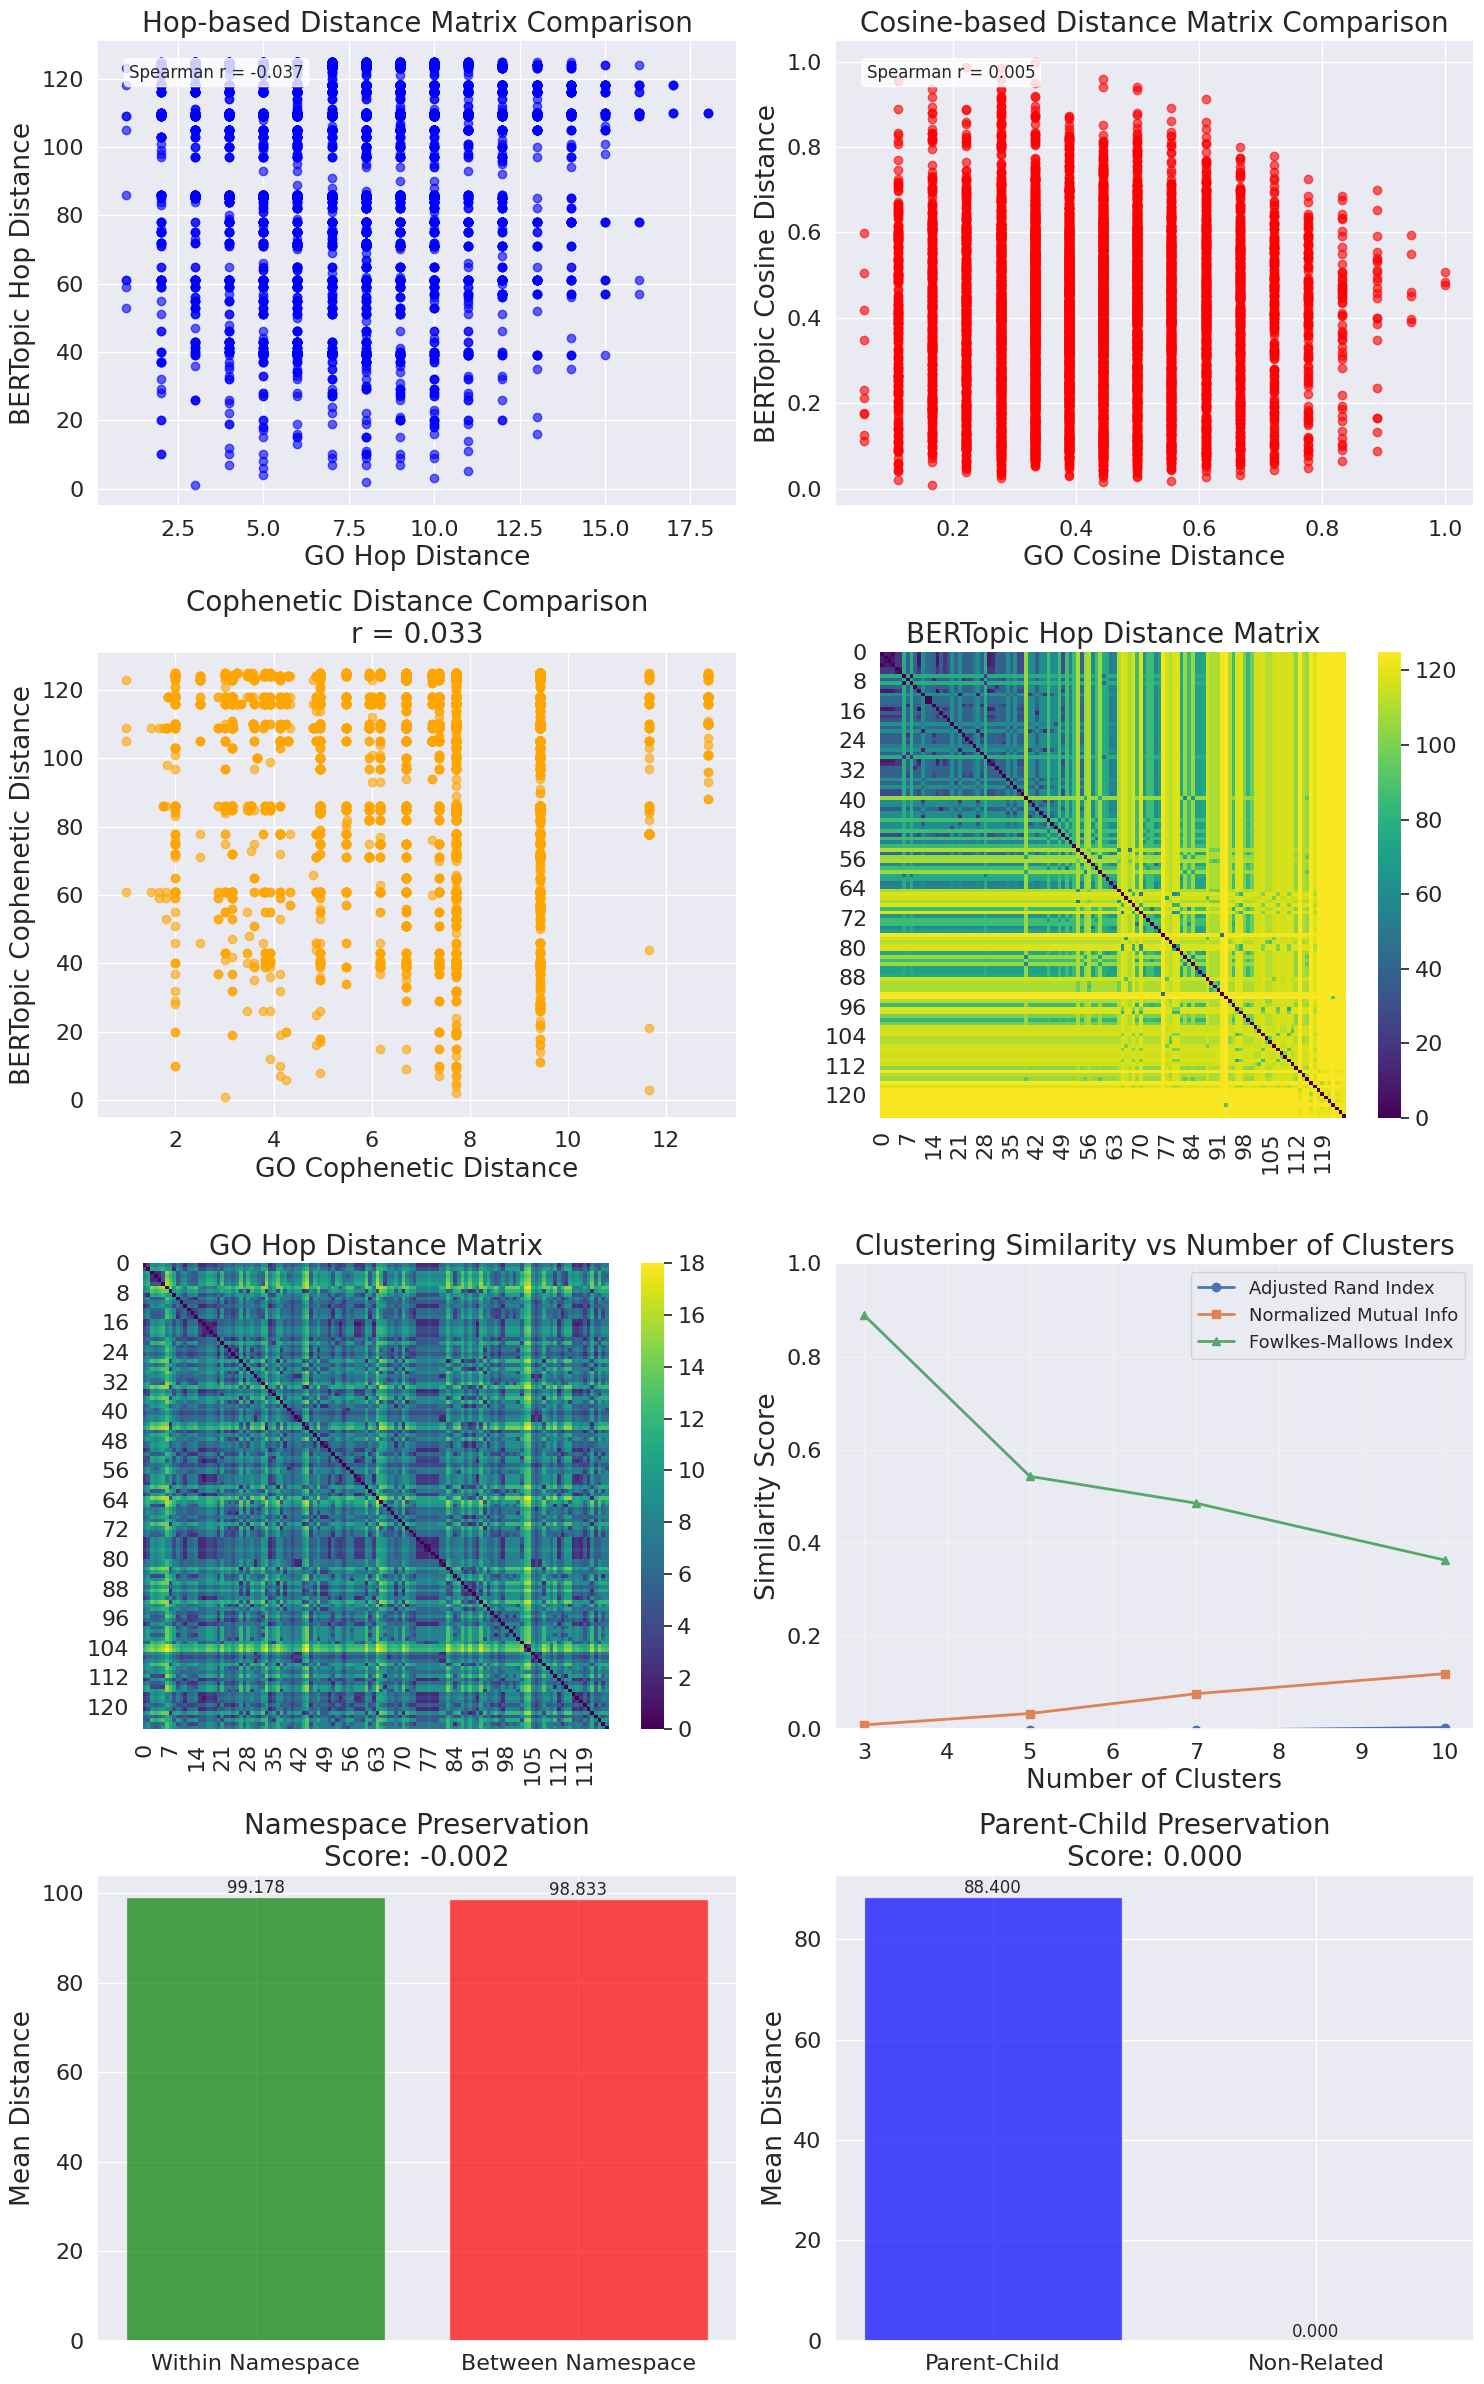

=== GO Hierarchy Comparison Results ===
Comprehensive Score: 0.0437
Score Range: [-1.0, 1.0] (higher is better)

=== Score Components ===
  hop_distance_correlation: -0.0075
  cosine_distance_correlation: 0.0005
  clustering_similarity: -0.0013
  namespace_preservation: 0.0000
  parent_child_preservation: 0.0000
  cophenetic_correlation: 0.0049
  fowlkes_mallows_index: 0.0570
  dendrogram_structure: -0.0500
  subtree_similarity: 0.0400

=== Detailed Metrics with Interpretations ===

--- Distance Correlation Metrics ---
  Hop-based Spearman Correlation: -0.0373 (poor)
    Range: (-1, 1), Spearman correlation measures monotonic relationship between distance matrices
  Cosine-based Spearman Correlation: 0.0053 (poor)
    Range: (-1, 1), Spearman correlation measures monotonic relationship between distance matrices

--- Clustering Similarity Metrics ---
  Average Adjusted Rand Index: -0.0087 (poor)
    Range: (-1, 1), ARI measures similarity between clusterings, adjusted for chance
  Avera

{'comprehensive_score': np.float64(0.04372683468564213),
 'score_components': {'hop_distance_correlation': np.float64(-0.007463850236934837),
  'cosine_distance_correlation': np.float64(0.0005348747994725834),
  'clustering_similarity': np.float64(-0.0013010559710116202),
  'namespace_preservation': 0.0,
  'parent_child_preservation': 0.0,
  'cophenetic_correlation': np.float64(0.004945652541052752),
  'fowlkes_mallows_index': np.float64(0.05701121355306324),
  'dendrogram_structure': np.float64(-0.04999999999999999),
  'subtree_similarity': 0.04000000000000001},
 'detailed_metrics': {'distance_metrics_cosine': {'comparison_type': 'cosine-based',
   'spearman_correlation': np.float64(0.005348747994725833),
   'spearman_p_value': np.float64(0.6350846924949898),
   'pearson_correlation': np.float64(-0.0037249148633455038),
   'pearson_p_value': np.float64(0.7410206238240905),
   'rmse': np.float64(0.2475503787763984),
   'normalized_rmse': np.float64(1.5496641144097258)},
  'distance_met

In [73]:
compare_hierarchies(go_dag, goslim_terms, topic_model, documents)

In [31]:
# --- Comparison of Tokenization Methods ---
df_train_comp = df_protein_go[df_protein_go['go_aspect'] == 'molecular_function'].reset_index(drop=True).copy()

tokenizer_cols_comp = list(tokenizer_list.keys())
go_col_comp = 'go_name'
token_len_thr_comp = 4
lambda_smooth_comp = 1.5
alpha_comp = 0.5
beta_comp = 0.8
theta_comp = 1.0

df_results = compare_tokenization_methods_hierarchical(
    df_train_comp, tokenizer_cols_comp, go_col_comp, go_dag, goslim_terms,
    vocab_lineage_list, token_len_thr_comp,
    lambda_smooth_comp, alpha_comp, beta_comp, theta_comp
)
display(df_results)

Comparing Tokenizers for Hierarchy:   0%|          | 0/6 [00:00<?, ?it/s]


--- Evaluating Hierarchy for Tokenizer: BPE 3200 ---
 GoSubDag: 206 sources in 335 GOs rcnt(True). 65 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()


100%|██████████| 34/34 [00:00<00:00, 448.92it/s]


 GoSubDag: 206 sources in 335 GOs rcnt(True). 65 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()


Comparing Tokenizers for Hierarchy:  17%|█▋        | 1/6 [00:02<00:13,  2.69s/it]


--- Evaluating Hierarchy for Tokenizer: BPE 6400 ---
 GoSubDag: 206 sources in 335 GOs rcnt(True). 65 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()


100%|██████████| 34/34 [00:00<00:00, 427.45it/s]


 GoSubDag: 206 sources in 335 GOs rcnt(True). 65 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()


Comparing Tokenizers for Hierarchy:  33%|███▎      | 2/6 [00:07<00:14,  3.74s/it]


--- Evaluating Hierarchy for Tokenizer: PUMA blosum62 0.7 0.05 3200 ---
 GoSubDag: 206 sources in 335 GOs rcnt(True). 65 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()


100%|██████████| 34/34 [00:00<00:00, 462.26it/s]


 GoSubDag: 206 sources in 335 GOs rcnt(True). 65 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()


Comparing Tokenizers for Hierarchy:  50%|█████     | 3/6 [00:11<00:11,  3.95s/it]


--- Evaluating Hierarchy for Tokenizer: PUMA blosum62 0.7 0.05 6400 ---
 GoSubDag: 206 sources in 335 GOs rcnt(True). 65 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()


100%|██████████| 34/34 [00:00<00:00, 447.08it/s]


 GoSubDag: 206 sources in 335 GOs rcnt(True). 65 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()


Comparing Tokenizers for Hierarchy:  67%|██████▋   | 4/6 [00:15<00:07,  3.93s/it]


--- Evaluating Hierarchy for Tokenizer: PUMA pre pam70 0.7 0.05 3200 ---
 GoSubDag: 206 sources in 335 GOs rcnt(True). 65 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()


100%|██████████| 34/34 [00:00<00:00, 463.68it/s]


 GoSubDag: 206 sources in 335 GOs rcnt(True). 65 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()


Comparing Tokenizers for Hierarchy:  83%|████████▎ | 5/6 [00:17<00:03,  3.44s/it]


--- Evaluating Hierarchy for Tokenizer: PUMA pre pam70 0.7 0.05 6400 ---
 GoSubDag: 206 sources in 335 GOs rcnt(True). 65 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()


100%|██████████| 34/34 [00:00<00:00, 447.58it/s]


 GoSubDag: 206 sources in 335 GOs rcnt(True). 65 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()


Comparing Tokenizers for Hierarchy: 100%|██████████| 6/6 [00:21<00:00,  3.63s/it]


tokenizer                 model  comprehensive_score  \
0                       BPE 3200     Standard BERTopic            -0.015929   
1                       BPE 3200  Graph-Aware BERTopic            -0.015724   
2                       BPE 6400     Standard BERTopic            -0.007799   
3                       BPE 6400  Graph-Aware BERTopic            -0.012632   
4    PUMA blosum62 0.7 0.05 3200     Standard BERTopic            -0.009911   
5    PUMA blosum62 0.7 0.05 3200  Graph-Aware BERTopic             0.007568   
6    PUMA blosum62 0.7 0.05 6400     Standard BERTopic            -0.026319   
7    PUMA blosum62 0.7 0.05 6400  Graph-Aware BERTopic            -0.002807   
8   PUMA pre pam70 0.7 0.05 3200     Standard BERTopic             0.000811   
9   PUMA pre pam70 0.7 0.05 3200  Graph-Aware BERTopic            -0.001568   
10  PUMA pre pam70 0.7 0.05 6400     Standard BERTopic            -0.031399   
11  PUMA pre pam70 0.7 0.05 6400  Graph-Aware BERTopic             0.010402   

    hop_distance_correlation  cosine_distance_correlation  \
0                  -0.013896                    -0.009510   
1                  -0.013897                    -0.009442   
2                  -0.018050                    -0.011469   
3                  -0.017857                    -0.011338   
4                  -0.010818                    -0.009499   
5                  -0.001630                    -0.008901   
6                  -0.019428                    -0.012195   
7                  -0.008134                    -0.008926   
8                  -0.008637                    -0.012453   
9                  -0.006477                    -0.009886   
10                 -0.023206                    -0.011986   
11                 -0.002541                    -0.006720   

    clustering_similarity  namespace_preservation  parent_child_preservation  \
0               -0.002768                     0.0                        0.0   
1               -0.002768                     0.0                        0.0   
2               -0.001591                     0.0                        0.0   
3               -0.001591                     0.0                        0.0   
4               -0.001289                     0.0                        0.0   
5                0.001521                     0.0                        0.0   
6               -0.002000                     0.0                        0.0   
7                0.000426                     0.0                        0.0   
8                0.003207                     0.0                        0.0   
9                0.006379                     0.0                        0.0   
10              -0.004705                     0.0                        0.0   
11               0.001388                     0.0                        0.0   

    cophenetic_correlation  fowlkes_mallows_index  dendrogram_structure  \
0                -0.020713               0.053179                 -0.05   
1                -0.020575               0.053179                 -0.05   
2                -0.023246               0.053701                 -0.05   
3                -0.023046               0.053701                 -0.05   
4                -0.020250               0.048611                 -0.05   
5                -0.017154               0.050399                 -0.05   
6                -0.023036               0.050339                 -0.05   
7                -0.018688               0.054739                 -0.05   
8                -0.020348               0.051542                 -0.05   
9                -0.019465               0.052881                 -0.05   
10               -0.023535               0.048699                 -0.05   
11               -0.016872               0.055148                 -0.05   

    subtree_similarity  
0             0.027778  
1             0.027778  
2             0.042857  
3             0.037500  
4             0.033333  
5             0.033333  
6        